

![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/NER.ipynb)




# **Detect entities in different languages**

## 1. Colab Setup

In [2]:
# Install java
!apt-get update -qq
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
!java -version

# Install pyspark
!pip install --ignore-installed -q pyspark==2.4.4

# Install Sparknlp
!pip install --ignore-installed spark-nlp

openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Using cached https://files.pythonhosted.org/packages/f1/de/6db7be666e7c8b70d39bcb0d956d3d983bcb06ea3895308c84d7a131dfb1/spark_nlp-2.6.2-py2.py3-none-any.whl


## 2. Start the Spark session

Import dependencies and start Spark session.

In [4]:
import os
import json
os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-8-openjdk-amd64"

import pandas as pd
import numpy as np

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

spark = sparknlp.start()

## 3. Select the DL model

For complete model list:

https://github.com/JohnSnowLabs/spark-nlp-models

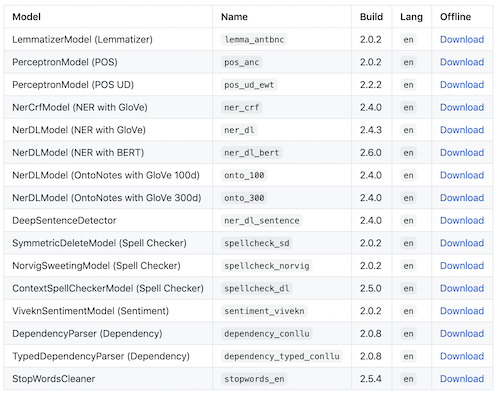

**Embeddings required for each NER model is specified. You can find them in the embeddings section**


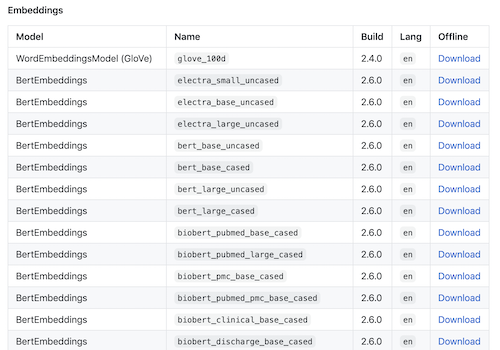

**For other languages:**
https://github.com/JohnSnowLabs/spark-nlp-models#multi-language

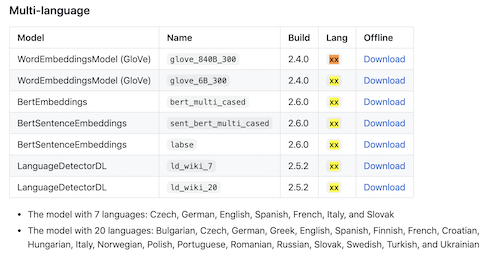

**NOTE: Typically small models (models having _sm at the end of their name) use glove_100d, medium models use glove_6B_300 and large models use glove_840B_300 embeddings**

## 4. A sample text in Danish for demo

In [7]:
### S
text_list = [
    """Mona Lisa er et oliemaleri fra det 16. århundrede skabt af Leonardo. Det afholdes på Louvre i Paris."""
]

## 5. Define Spark NLP pipeline

In [12]:
documentAssembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

## for languages other than english we use xx language embeddings
embeddings = WordEmbeddingsModel.pretrained('glove_6B_300', lang='xx') \
        .setInputCols(["document", 'token']) \
        .setOutputCol("embeddings")

#embeddings = BertEmbeddings.pretrained(name='bert_base_cased', lang='en') \
#        .setInputCols(['document', 'token']) \
#        .setOutputCol('embeddings')

# select your desired model and define language
ner_model = NerDLModel.pretrained('dane_ner_6B_300', lang='da') \
    .setInputCols(['document', 'token', 'embeddings']) \
    .setOutputCol('ner')

ner_converter = NerConverter() \
    .setInputCols(['document', 'token', 'ner']) \
    .setOutputCol('ner_chunk')

nlp_pipeline = Pipeline(stages=[
    documentAssembler, 
    tokenizer,
    embeddings,
    ner_model,
    ner_converter
])

glove_6B_300 download started this may take some time.
Approximate size to download 426.2 MB
[OK!]
dane_ner_6B_300 download started this may take some time.
Approximate size to download 14.2 MB
[OK!]


## 6. Run the pipeline

In [13]:
empty_df = spark.createDataFrame([['']]).toDF('text')
pipeline_model = nlp_pipeline.fit(empty_df)
df = spark.createDataFrame(pd.DataFrame({'text': text_list}))
result = pipeline_model.transform(df)

## 7. Visualize results

In [14]:
result.select(
    F.explode(
        F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata')
    ).alias("cols")
).select(
    F.expr("cols['0']").alias('chunk'),
    F.expr("cols['1']['entity']").alias('ner_label')
).show(truncate=False)

+---------+---------+
|chunk    |ner_label|
+---------+---------+
|Mona Lisa|PER      |
|Leonardo |PER      |
|Det      |LOC      |
|Louvre   |LOC      |
|Paris    |LOC      |
+---------+---------+

